In [118]:
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
import os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pyLDAvis

In [65]:
#Loading environment variables from .env
load_dotenv()

True

## Loading Web URLs

In [130]:
# Step 1: Open the file
with open('web_urls.txt', 'r') as file:
    # Step 2: Read the lines
    lines = file.readlines()

# Step 3: Strip newline characters and store the values as a list
urls = [line.strip() for line in lines]

# Print the list to verify
print(urls)

['https://www.torontomu.ca/tmumobile/faq/', 'https://www.torontomu.ca/mba/contact-faq/', 'https://www.torontomu.ca/tedrogersschool/business-management/faqs/', 'https://www.torontomu.ca/tedrogersschool/fit-for-business/faqs/', 'https://www.torontomu.ca/tedrogersschool/master-science-management/admissions/faqs/', 'https://www.torontomu.ca/tedrogersschool/business-career-hub/co-op/faq/', 'https://www.torontomu.ca/tedrogersschool/pmdiploma/faq/', 'https://www.torontomu.ca/student-financial-assistance/osap/faqs/', 'https://www.torontomu.ca/student-care/about/faq', 'https://www.torontomu.ca/svz/about/faq/', 'https://www.torontomu.ca/svp-review/frequently-asked-questions/', 'https://www.torontomu.ca/discoveryzone/about/faqs/', 'https://www.torontomu.ca/school-of-urban-and-regional-planning/graduate/admissions/faqs/', 'https://www.torontomu.ca/social-work/graduate/faqs/', 'https://www.torontomu.ca/social-work/undergraduate/bsw-faqs/', 'https://www.torontomu.ca/nutrition/undergraduate/nutrition

In [131]:
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(urls)
docs = loader.load()

In [132]:
print(len(docs))

55


In [133]:
text_content=[]

for doc in docs:
    text_content.append(doc.page_content)

In [134]:
import pandas as pd
# dictionary of lists 
dict = {'page_content': text_content} 
   
df = pd.DataFrame(dict)

In [135]:
print(df.head(9))

                                                                                          page_content
0  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Toronto Metropolitan University\r\n    \n\n\n\n\n\n\n\n\n\...
1  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nContact Us & FAQs - Master of Business Administration - Toronto ...
2  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs about the School of Business Management - Ted Rogers Sc...
3  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQS - Ted Rogers School of Management - Toronto Metropolitan Un...
4  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Master of Science in Management - Ted Rogers School of Ma...
5  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Business Career Hub - Ted Rogers School of Management - To...
6  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFrequently Asked Questions - Ted Rogers School of Manage...
7  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFrequently Asked Questions - Student Financial Assistance - Toro...
8  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Student Care - Toronto Metropol

## Preprocessing

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

In [137]:
df_processed=df.copy()

In [7]:
import pandas as pd

df_tokens=pd.read_csv("datasets/combined_faqs.csv",encoding_errors="ignore")
df_tokens['tokenized'] = df_tokens['document'].apply(word_tokenize)
df_tokens['lower'] = df_tokens['tokenized'].apply(lambda x: [word.lower() for word in x])

#Removing punctuation
punc = string.punctuation
df_tokens['no_punc'] = df_tokens['lower'].apply(lambda x: [word for word in x if word not in punc])
df_tokens.head()

,Department,Topic,Sub_Topic,question_name,question_url,question_answer,document,tokenized,lower,no_punc
0,Daphne Cockwell Scholl of Nursing,Graduate,Current Students,How do I appeal a grade?,https://www.torontomu.ca/nursing/graduate/stud...,YSGS Policies and Guidelines,How do I appeal a grade?\nYSGS Policies and Gu...,"[How, do, I, appeal, a, grade, ?, YSGS, Polici...","[how, do, i, appeal, a, grade, ?, ysgs, polici...","[how, do, i, appeal, a, grade, ysgs, policies,..."
1,Future Students,Undergraduate,Admissions,I'm a current/previous TMU applicant or underg...,https://www.torontomu.ca/admissions/undergradu...,You're not required to submit official transcr...,I'm a current/previous TMU applicant or underg...,"[I, 'm, a, current/previous, TMU, applicant, o...","[i, 'm, a, current/previous, tmu, applicant, o...","[i, 'm, a, current/previous, tmu, applicant, o..."
2,Ted Rogers School of Management,Fit for Business,Fit for Business,How do I pay for tuition for business manageme...,https://www.torontomu.ca/tedrogersschool/fit-f...,Your undergraduate tuition and fees are paid t...,How do I pay for tuition for business manageme...,"[How, do, I, pay, for, tuition, for, business,...","[how, do, i, pay, for, tuition, for, business,...","[how, do, i, pay, for, tuition, for, business,..."
3,School of Social Work,Graduate,Master of Social Work,Who will my supervisor be for Master of Social...,https://www.torontomu.ca/social-work/graduate/...,Your supervisor will be assigned to you by the...,Who will my supervisor be for Master of Social...,"[Who, will, my, supervisor, be, for, Master, o...","[who, will, my, supervisor, be, for, master, o...","[who, will, my, supervisor, be, for, master, o..."
4,Ted Rogers School of Management,Business Management,Future Students,What Majors are offered at the Ted Rogers Scho...,https://www.torontomu.ca/tedrogersschool/busin...,Your selected major will appear on your degree...,What Majors are offered at the Ted Rogers Scho...,"[What, Majors, are, offered, at, the, Ted, Rog...","[what, majors, are, offered, at, the, ted, rog...","[what, majors, are, offered, at, the, ted, rog..."


In [16]:
for index,row in df_tokens.iterrows():

    count=0
    for i in row['no_punc']:
        count=count+1
   
    df_tokens.loc[index, 'count'] =count


In [17]:
df_tokens.head()

,Department,Topic,Sub_Topic,question_name,question_url,question_answer,document,tokenized,lower,no_punc,count
0,Daphne Cockwell Scholl of Nursing,Graduate,Current Students,How do I appeal a grade?,https://www.torontomu.ca/nursing/graduate/stud...,YSGS Policies and Guidelines,How do I appeal a grade?\nYSGS Policies and Gu...,"[How, do, I, appeal, a, grade, ?, YSGS, Polici...","[how, do, i, appeal, a, grade, ?, ysgs, polici...","[how, do, i, appeal, a, grade, ysgs, policies,...",10
1,Future Students,Undergraduate,Admissions,I'm a current/previous TMU applicant or underg...,https://www.torontomu.ca/admissions/undergradu...,You're not required to submit official transcr...,I'm a current/previous TMU applicant or underg...,"[I, 'm, a, current/previous, TMU, applicant, o...","[i, 'm, a, current/previous, tmu, applicant, o...","[i, 'm, a, current/previous, tmu, applicant, o...",81
2,Ted Rogers School of Management,Fit for Business,Fit for Business,How do I pay for tuition for business manageme...,https://www.torontomu.ca/tedrogersschool/fit-f...,Your undergraduate tuition and fees are paid t...,How do I pay for tuition for business manageme...,"[How, do, I, pay, for, tuition, for, business,...","[how, do, i, pay, for, tuition, for, business,...","[how, do, i, pay, for, tuition, for, business,...",102
3,School of Social Work,Graduate,Master of Social Work,Who will my supervisor be for Master of Social...,https://www.torontomu.ca/social-work/graduate/...,Your supervisor will be assigned to you by the...,Who will my supervisor be for Master of Social...,"[Who, will, my, supervisor, be, for, Master, o...","[who, will, my, supervisor, be, for, master, o...","[who, will, my, supervisor, be, for, master, o...",38
4,Ted Rogers School of Management,Business Management,Future Students,What Majors are offered at the Ted Rogers Scho...,https://www.torontomu.ca/tedrogersschool/busin...,Your selected major will appear on your degree...,What Majors are offered at the Ted Rogers Scho...,"[What, Majors, are, offered, at, the, Ted, Rog...","[what, majors, are, offered, at, the, ted, rog...","[what, majors, are, offered, at, the, ted, rog...",94


In [21]:
df_tokens.groupby(['Department'])['count'].sum().sort_values(ascending=False)



Department
Computing and Communications Services                  9482
Ted Rogers School of Management                        8805
Daphne Cockwell Scholl of Nursing                      7937
Creative Industries                                    6165
Future Students                                        5290
Office of the General Counsel and Board Secretariat    4921
Centre of Excellence in Learning and Teaching          2871
Admissions                                             2520
School of Medicine                                     2264
Student Financial Assistance                           2097
Faculty of Engineering & Architectural Science         2045
 Budget                                                1877
Philosophy                                             1761
School of Urban and Regional Planning                  1640
Alumni                                                 1444
School of Social Work                                  1316
Social Ventures Zone         

In [138]:
#Tokenization
df_processed['tokenized'] = df_processed['page_content'].apply(word_tokenize)
df_processed.head()

,page_content,tokenized
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Toronto Metropolitan University\r\n \n\n\n\n\n\n\n\n\n\...,"[FAQ, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, navigation, Toggle,..."
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nContact Us & FAQs - Master of Business Administration - Toronto ...,"[Contact, Us, &, FAQs, -, Master, of, Business, Administration, -, Toronto, Metropolitan, Univer..."
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs about the School of Business Management - Ted Rogers Sc...,"[FAQs, about, the, School, of, Business, Management, -, Ted, Rogers, School, of, Management, -, ..."
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQS - Ted Rogers School of Management - Toronto Metropolitan Un...,"[FAQS, -, Ted, Rogers, School, of, Management, -, Toronto, Metropolitan, University, Skip, to, M..."
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Master of Science in Management - Ted Rogers School of Ma...,"[FAQs, -, Master, of, Science, in, Management, -, Ted, Rogers, School, of, Management, -, Toront..."


In [139]:
#Converting to lowercase
df_processed['lower'] = df_processed['tokenized'].apply(lambda x: [word.lower() for word in x])
df_processed.head()

,page_content,tokenized,lower
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Toronto Metropolitan University\r\n \n\n\n\n\n\n\n\n\n\...,"[FAQ, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, navigation, Toggle,...","[faq, -, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, toggle,..."
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nContact Us & FAQs - Master of Business Administration - Toronto ...,"[Contact, Us, &, FAQs, -, Master, of, Business, Administration, -, Toronto, Metropolitan, Univer...","[contact, us, &, faqs, -, master, of, business, administration, -, toronto, metropolitan, univer..."
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs about the School of Business Management - Ted Rogers Sc...,"[FAQs, about, the, School, of, Business, Management, -, Ted, Rogers, School, of, Management, -, ...","[faqs, about, the, school, of, business, management, -, ted, rogers, school, of, management, -, ..."
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQS - Ted Rogers School of Management - Toronto Metropolitan Un...,"[FAQS, -, Ted, Rogers, School, of, Management, -, Toronto, Metropolitan, University, Skip, to, M...","[faqs, -, ted, rogers, school, of, management, -, toronto, metropolitan, university, skip, to, m..."
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Master of Science in Management - Ted Rogers School of Ma...,"[FAQs, -, Master, of, Science, in, Management, -, Ted, Rogers, School, of, Management, -, Toront...","[faqs, -, master, of, science, in, management, -, ted, rogers, school, of, management, -, toront..."


In [140]:
#Removing punctuation
punc = string.punctuation
df_processed['no_punc'] = df_processed['lower'].apply(lambda x: [word for word in x if word not in punc])
df_processed.head()

,page_content,tokenized,lower,no_punc
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Toronto Metropolitan University\r\n \n\n\n\n\n\n\n\n\n\...,"[FAQ, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, navigation, Toggle,...","[faq, -, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, toggle,...","[faq, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, toggle, in..."
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nContact Us & FAQs - Master of Business Administration - Toronto ...,"[Contact, Us, &, FAQs, -, Master, of, Business, Administration, -, Toronto, Metropolitan, Univer...","[contact, us, &, faqs, -, master, of, business, administration, -, toronto, metropolitan, univer...","[contact, us, faqs, master, of, business, administration, toronto, metropolitan, university, ski..."
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs about the School of Business Management - Ted Rogers Sc...,"[FAQs, about, the, School, of, Business, Management, -, Ted, Rogers, School, of, Management, -, ...","[faqs, about, the, school, of, business, management, -, ted, rogers, school, of, management, -, ...","[faqs, about, the, school, of, business, management, ted, rogers, school, of, management, toront..."
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQS - Ted Rogers School of Management - Toronto Metropolitan Un...,"[FAQS, -, Ted, Rogers, School, of, Management, -, Toronto, Metropolitan, University, Skip, to, M...","[faqs, -, ted, rogers, school, of, management, -, toronto, metropolitan, university, skip, to, m...","[faqs, ted, rogers, school, of, management, toronto, metropolitan, university, skip, to, main, c..."
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Master of Science in Management - Ted Rogers School of Ma...,"[FAQs, -, Master, of, Science, in, Management, -, Ted, Rogers, School, of, Management, -, Toront...","[faqs, -, master, of, science, in, management, -, ted, rogers, school, of, management, -, toront...","[faqs, master, of, science, in, management, ted, rogers, school, of, management, toronto, metrop..."


In [59]:
#Removing stop words
# stop_words = set(stopwords.words('english'))
# df_processed['stopwords_removed'] = df_processed['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
# df_processed.head()

,page_content,tokenized,lower,no_punc,stopwords_removed
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Graduate - Toronto Metropolitan University\r\n \n\n...,"[FAQ, -, Graduate, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, naviga...","[faq, -, graduate, -, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faq, graduate, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, ...","[faq, graduate, toronto, metropolitan, university, skip, main, content, toggle, navigation, togg..."
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Student Care - Toronto Metropolitan University\r\n \n\...,"[FAQs, -, Student, Care, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, ...","[faqs, -, student, care, -, toronto, metropolitan, university, skip, to, main, content, toggle, ...","[faqs, student, care, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faqs, student, care, toronto, metropolitan, university, skip, main, content, toggle, navigation..."
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFrequently Asked Questions (FAQs) - Nursing Central Placement Of...,"[Frequently, Asked, Questions, (, FAQs, ), -, Nursing, Central, Placement, Office, -, Toronto, M...","[frequently, asked, questions, (, faqs, ), -, nursing, central, placement, office, -, toronto, m...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,..."
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - T...,"[Graduate, admissions, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan,...","[graduate, admissions, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan,...","[graduate, admissions, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, unive...","[graduate, admissions, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, universit..."
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate FAQs - Daphne Cockwell School of Nursing - Toronto Metr...,"[Graduate, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan, University,...","[graduate, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan, university,...","[graduate, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, university, skip,...","[graduate, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, university, skip, mai..."


In [60]:
# #POS tags
# df_processed['pos_tags'] = df_processed['stopwords_removed'].apply(nltk.tag.pos_tag)
# df_processed.head()

,page_content,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Graduate - Toronto Metropolitan University\r\n \n\n...,"[FAQ, -, Graduate, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, naviga...","[faq, -, graduate, -, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faq, graduate, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, ...","[faq, graduate, toronto, metropolitan, university, skip, main, content, toggle, navigation, togg...","[(faq, JJ), (graduate, NN), (toronto, NN), (metropolitan, JJ), (university, NN), (skip, NN), (ma..."
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Student Care - Toronto Metropolitan University\r\n \n\...,"[FAQs, -, Student, Care, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, ...","[faqs, -, student, care, -, toronto, metropolitan, university, skip, to, main, content, toggle, ...","[faqs, student, care, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faqs, student, care, toronto, metropolitan, university, skip, main, content, toggle, navigation...","[(faqs, JJ), (student, NN), (care, NN), (toronto, IN), (metropolitan, JJ), (university, NN), (sk..."
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFrequently Asked Questions (FAQs) - Nursing Central Placement Of...,"[Frequently, Asked, Questions, (, FAQs, ), -, Nursing, Central, Placement, Office, -, Toronto, M...","[frequently, asked, questions, (, faqs, ), -, nursing, central, placement, office, -, toronto, m...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[(frequently, RB), (asked, VBN), (questions, NNS), (faqs, VBP), (nursing, JJ), (central, JJ), (p..."
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - T...,"[Graduate, admissions, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan,...","[graduate, admissions, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan,...","[graduate, admissions, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, unive...","[graduate, admissions, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, universit...","[(graduate, NN), (admissions, NNS), (faqs, VBP), (daphne, NN), (cockwell, NN), (school, NN), (nu..."
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate FAQs - Daphne Cockwell School of Nursing - Toronto Metr...,"[Graduate, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan, University,...","[graduate, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan, university,...","[graduate, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, university, skip,...","[graduate, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, university, skip, mai...","[(graduate, NN), (faqs, NN), (daphne, NN), (cockwell, VBP), (school, NN), (nursing, NN), (toront..."


In [61]:
#Converting POS to wordnet format to use lemmatizer

# def get_wordnet_pos(tag):
#     if tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN
# df_processed['wordnet_pos'] = df_processed['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
# df_processed.head()

,page_content,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Graduate - Toronto Metropolitan University\r\n \n\n...,"[FAQ, -, Graduate, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, naviga...","[faq, -, graduate, -, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faq, graduate, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, ...","[faq, graduate, toronto, metropolitan, university, skip, main, content, toggle, navigation, togg...","[(faq, JJ), (graduate, NN), (toronto, NN), (metropolitan, JJ), (university, NN), (skip, NN), (ma...","[(faq, a), (graduate, n), (toronto, n), (metropolitan, a), (university, n), (skip, n), (main, a)..."
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Student Care - Toronto Metropolitan University\r\n \n\...,"[FAQs, -, Student, Care, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, ...","[faqs, -, student, care, -, toronto, metropolitan, university, skip, to, main, content, toggle, ...","[faqs, student, care, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faqs, student, care, toronto, metropolitan, university, skip, main, content, toggle, navigation...","[(faqs, JJ), (student, NN), (care, NN), (toronto, IN), (metropolitan, JJ), (university, NN), (sk...","[(faqs, a), (student, n), (care, n), (toronto, n), (metropolitan, a), (university, n), (skip, n)..."
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFrequently Asked Questions (FAQs) - Nursing Central Placement Of...,"[Frequently, Asked, Questions, (, FAQs, ), -, Nursing, Central, Placement, Office, -, Toronto, M...","[frequently, asked, questions, (, faqs, ), -, nursing, central, placement, office, -, toronto, m...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[(frequently, RB), (asked, VBN), (questions, NNS), (faqs, VBP), (nursing, JJ), (central, JJ), (p...","[(frequently, r), (asked, v), (questions, n), (faqs, v), (nursing, a), (central, a), (placement,..."
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - T...,"[Graduate, admissions, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan,...","[graduate, admissions, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan,...","[graduate, admissions, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, unive...","[graduate, admissions, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, universit...","[(graduate, NN), (admissions, NNS), (faqs, VBP), (daphne, NN), (cockwell, NN), (school, NN), (nu...","[(graduate, n), (admissions, n), (faqs, v), (daphne, n), (cockwell, n), (school, n), (nursing, n..."
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate FAQs - Daphne Cockwell School of Nursing - Toronto Metr...,"[Graduate, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan, University,...","[graduate, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan, university,...","[graduate, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, university, skip,...","[graduate, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, university, skip, mai...","[(graduate, NN), (faqs, NN), (daphne, NN), (cockwell, VBP), (school, NN), (nursing, NN), (toront...","[(graduate, n), (faqs, n), (daphne, n), (cockwell, v), (school, n), (nursing, n), (toronto, n), ..."


In [62]:
#Applying lemmatization
# wnl = WordNetLemmatizer()
# df_processed['lemmatized'] = df_processed['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
# df_processed.head()

,page_content,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Graduate - Toronto Metropolitan University\r\n \n\n...,"[FAQ, -, Graduate, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, naviga...","[faq, -, graduate, -, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faq, graduate, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, ...","[faq, graduate, toronto, metropolitan, university, skip, main, content, toggle, navigation, togg...","[(faq, JJ), (graduate, NN), (toronto, NN), (metropolitan, JJ), (university, NN), (skip, NN), (ma...","[(faq, a), (graduate, n), (toronto, n), (metropolitan, a), (university, n), (skip, n), (main, a)...","[faq, graduate, toronto, metropolitan, university, skip, main, content, toggle, navigation, togg..."
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Student Care - Toronto Metropolitan University\r\n \n\...,"[FAQs, -, Student, Care, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, ...","[faqs, -, student, care, -, toronto, metropolitan, university, skip, to, main, content, toggle, ...","[faqs, student, care, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faqs, student, care, toronto, metropolitan, university, skip, main, content, toggle, navigation...","[(faqs, JJ), (student, NN), (care, NN), (toronto, IN), (metropolitan, JJ), (university, NN), (sk...","[(faqs, a), (student, n), (care, n), (toronto, n), (metropolitan, a), (university, n), (skip, n)...","[faqs, student, care, toronto, metropolitan, university, skip, main, content, toggle, navigation..."
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFrequently Asked Questions (FAQs) - Nursing Central Placement Of...,"[Frequently, Asked, Questions, (, FAQs, ), -, Nursing, Central, Placement, Office, -, Toronto, M...","[frequently, asked, questions, (, faqs, ), -, nursing, central, placement, office, -, toronto, m...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[(frequently, RB), (asked, VBN), (questions, NNS), (faqs, VBP), (nursing, JJ), (central, JJ), (p...","[(frequently, r), (asked, v), (questions, n), (faqs, v), (nursing, a), (central, a), (placement,...","[frequently, ask, question, faqs, nursing, central, placement, office, toronto, metropolitan, un..."
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - T...,"[Graduate, admissions, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan,...","[graduate, admissions, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan,...","[graduate, admissions, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, unive...","[graduate, admissions, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, universit...","[(graduate, NN), (admissions, NNS), (faqs, VBP), (daphne, NN), (cockwell, NN), (school, NN), (nu...","[(graduate, n), (admissions, n), (faqs, v), (daphne, n), (cockwell, n), (school, n), (nursing, n...","[graduate, admission, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, university..."
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate FAQs - Daphne Cockwell School of Nursing - Toronto Metr...,"[Graduate, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan, University,...","[graduate, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan, university,...","[graduate, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, university, skip,...","[graduate, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, university, skip, mai...","[(graduate, NN), (faqs, NN), (daphne, NN), (cockwell, VBP), (school, NN), (nursing, NN), (toront...","[(graduate, n), (faqs, n), (daphne, n), (

In [26]:
print(text_content)

['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Graduate - Toronto Metropolitan University\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to Main Content\n\n\n\n \n\n\nToggle navigation \n\n\nToggle information \n\n\nToggle search \n\n\n\n\n\nSearch Site and People\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tInfo for \n\n\n\nFuture Students\nCurrent Students\nFaculty and Staff\nTeachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tCounsellors\nAlumni\nMedia\nDonors\n\nFuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nCurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nFaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Staff\nTeachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Counsellors\nAlumni\nMedia\nDonors\n\n\nAbout\nPrograms\nAdmissions\nCampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tLife\nResearch & Innovation\nEquity & Community Inclusion\n\nApply\nVisit\nGive\n\nmy.torontomu\n\n\n Menu\n\n\nAbout\nPrograms\nAdmissions\nCampus Life\nResearch & Innovation\nEquity & Community Inclusion\n\n\n\n\n\n\n\n\n\n\

In [141]:
# Converting texts into lowercase
text_content_lowercased = [s.lower() for s in text_content]


In [142]:
print(text_content_lowercased)

["\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nfaq - toronto metropolitan university\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nskip to main content\n\n\n\n \n\n\ntoggle navigation \n\n\ntoggle information \n\n\ntoggle search \n\n\n\n\n\nsearch site and people\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tinfo for \n\n\n\nfuture students\ncurrent students\nfaculty and staff\nteachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tcounsellors\nalumni\nmedia\ndonors\n\nfuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tstudents\ncurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tstudents\nfaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand staff\nteachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand counsellors\nalumni\nmedia\ndonors\n\n\nabout\nprograms\nadmissions\ncampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tlife\nresearch & innovation\nequity & community inclusion\n\napply\nvisit\ngive\n\nmy.torontomu\n\n\n menu\n\n\nabout\nprograms\nadmissions\ncampus life\nresearch & innovation\nequity & community inclusion\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

In [143]:
# Function to remove HTML tags from a string
from bs4 import BeautifulSoup
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Apply the function to the list of strings
cleaned_strings = [remove_html_tags(html) for html in text_content_lowercased]


In [144]:
print(cleaned_strings)

["\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nfaq - toronto metropolitan university\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nskip to main content\n\n\n\n \n\n\ntoggle navigation \n\n\ntoggle information \n\n\ntoggle search \n\n\n\n\n\nsearch site and people\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tinfo for \n\n\n\nfuture students\ncurrent students\nfaculty and staff\nteachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tcounsellors\nalumni\nmedia\ndonors\n\nfuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tstudents\ncurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tstudents\nfaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand staff\nteachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand counsellors\nalumni\nmedia\ndonors\n\n\nabout\nprograms\nadmissions\ncampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tlife\nresearch & innovation\nequity & community inclusion\n\napply\nvisit\ngive\n\nmy.torontomu\n\n\n menu\n\n\nabout\nprograms\nadmissions\ncampus life\nresearch & innovation\nequity & community inclusion\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

In [145]:
#Removing non-ASCII characters
import unidecode

# Apply the function to the list of strings
removed_non_ascii_strings = [unidecode.unidecode(text) for text in cleaned_strings]

In [146]:
print(removed_non_ascii_strings)

["\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nfaq - toronto metropolitan university\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nskip to main content\n\n\n\n \n\n\ntoggle navigation \n\n\ntoggle information \n\n\ntoggle search \n\n\n\n\n\nsearch site and people\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tinfo for \n\n\n\nfuture students\ncurrent students\nfaculty and staff\nteachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tcounsellors\nalumni\nmedia\ndonors\n\nfuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tstudents\ncurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tstudents\nfaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand staff\nteachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand counsellors\nalumni\nmedia\ndonors\n\n\nabout\nprograms\nadmissions\ncampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tlife\nresearch & innovation\nequity & community inclusion\n\napply\nvisit\ngive\n\nmy.torontomu\n\n\n menu\n\n\nabout\nprograms\nadmissions\ncampus life\nresearch & innovation\nequity & community inclusion\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

In [37]:
#Removing stop words

# # Get the list of stop words
# stop_words = set(stopwords.words('english'))

# # Function to remove stop words from a single string
# def remove_stopwords(text):
#     word_tokens = word_tokenize(text)
#     filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
#     return ' '.join(filtered_text)

# # Apply the function to the list of text
# removed_stop_words_list = [remove_stopwords(text) for text in removed_non_ascii_strings]



In [38]:
# print(removed_stop_words_list)

["faq - graduate - toronto metropolitan university skip main content toggle navigation toggle information toggle search search site people info future students current students faculty staff teachers counsellors alumni media donors future students current students faculty staff teachers counsellors alumni media donors programs admissions campus life research & innovation equity & community inclusion apply visit give my.torontomu menu programs admissions campus life research & innovation equity & community inclusion graduate postdoctoral studies home toggle navigation programs future students / admissions international students graduate student guide calendar postdoctoral fellows news / events faculty / staff contact us future students / admissions toggle navigation apply financing studies areas interest people research student life upcoming info sessions indigenous graduate education main content area frequently asked questions ( faq ) reference faq admission faq open close 1. admissio

In [39]:
#Remove puntuation marks

# import string


# # Function to remove punctuation from a string
# def remove_punctuation(text):
#     return text.translate(str.maketrans('', '', string.punctuation))

# # Apply the function to the list of strings
# removed_punctuatin_marks_text_list = [remove_punctuation(text) for text in removed_stop_words_list]



In [40]:
# print(removed_punctuatin_marks_text_list)

['faq  graduate  toronto metropolitan university skip main content toggle navigation toggle information toggle search search site people info future students current students faculty staff teachers counsellors alumni media donors future students current students faculty staff teachers counsellors alumni media donors programs admissions campus life research  innovation equity  community inclusion apply visit give mytorontomu menu programs admissions campus life research  innovation equity  community inclusion graduate postdoctoral studies home toggle navigation programs future students  admissions international students graduate student guide calendar postdoctoral fellows news  events faculty  staff contact us future students  admissions toggle navigation apply financing studies areas interest people research student life upcoming info sessions indigenous graduate education main content area frequently asked questions  faq  reference faq admission faq open close 1 admission requirements

## Exploratory Data Analysis(EDA)

In [147]:
# import pandas as pd
# # dictionary of lists 
# dict_2 = {'page_content_preprocessed': removed_punctuatin_marks_text_list} 
df_preprocessed = df_processed.copy()

In [148]:
# df_preprocessed['lemma_str'] = [' '.join(map(str,l)) for l in df_preprocessed['lemmatized']]
# df_preprocessed.head()

KeyError: 'lemmatized'

### Sentiment Polarity

In [104]:

# df_preprocessed['sentiment'] = df_preprocessed['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
# df_preprocessed.head()

,page_content,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str,sentiment
0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Graduate - Toronto Metropolitan University\r\n \n\n...,"[FAQ, -, Graduate, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, naviga...","[faq, -, graduate, -, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faq, graduate, toronto, metropolitan, university, skip, to, main, content, toggle, navigation, ...","[faq, graduate, toronto, metropolitan, university, skip, main, content, toggle, navigation, togg...","[(faq, JJ), (graduate, NN), (toronto, NN), (metropolitan, JJ), (university, NN), (skip, NN), (ma...","[(faq, a), (graduate, n), (toronto, n), (metropolitan, a), (university, n), (skip, n), (main, a)...","[faq, graduate, toronto, metropolitan, university, skip, main, content, toggle, navigation, togg...",faq graduate toronto metropolitan university skip main content toggle navigation toggle informat...,0.086105
1,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQs - Student Care - Toronto Metropolitan University\r\n \n\...,"[FAQs, -, Student, Care, -, Toronto, Metropolitan, University, Skip, to, Main, Content, Toggle, ...","[faqs, -, student, care, -, toronto, metropolitan, university, skip, to, main, content, toggle, ...","[faqs, student, care, toronto, metropolitan, university, skip, to, main, content, toggle, naviga...","[faqs, student, care, toronto, metropolitan, university, skip, main, content, toggle, navigation...","[(faqs, JJ), (student, NN), (care, NN), (toronto, IN), (metropolitan, JJ), (university, NN), (sk...","[(faqs, a), (student, n), (care, n), (toronto, n), (metropolitan, a), (university, n), (skip, n)...","[faqs, student, care, toronto, metropolitan, university, skip, main, content, toggle, navigation...",faqs student care toronto metropolitan university skip main content toggle navigation toggle inf...,0.025376
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFrequently Asked Questions (FAQs) - Nursing Central Placement Of...,"[Frequently, Asked, Questions, (, FAQs, ), -, Nursing, Central, Placement, Office, -, Toronto, M...","[frequently, asked, questions, (, faqs, ), -, nursing, central, placement, office, -, toronto, m...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[frequently, asked, questions, faqs, nursing, central, placement, office, toronto, metropolitan,...","[(frequently, RB), (asked, VBN), (questions, NNS), (faqs, VBP), (nursing, JJ), (central, JJ), (p...","[(frequently, r), (asked, v), (questions, n), (faqs, v), (nursing, a), (central, a), (placement,...","[frequently, ask, question, faqs, nursing, central, placement, office, toronto, metropolitan, un...",frequently ask question faqs nursing central placement office toronto metropolitan university sk...,0.055704
3,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - T...,"[Graduate, admissions, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan,...","[graduate, admissions, faqs, -, daphne, cockwell, school, of, nursing, -, toronto, metropolitan,...","[graduate, admissions, faqs, daphne, cockwell, school, of, nursing, toronto, metropolitan, unive...","[graduate, admissions, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, universit...","[(graduate, NN), (admissions, NNS), (faqs, VBP), (daphne, NN), (cockwell, NN), (school, NN), (nu...","[(graduate, n), (admissions, n), (faqs, v), (daphne, n), (cockwell, n), (school, n), (nursing, n...","[graduate, admission, faqs, daphne, cockwell, school, nursing, toronto, metropolitan, university...",graduate admission faqs daphne cockwell school nursing toronto metropolitan university skip main...,0.091188
4,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate FAQs - Daphne Cockwell School of Nursing - Toronto Metr...,"[Graduate, FAQs, -, Daphne, Cockwell, School, of, Nursing, -, Toronto, Metropolitan, University

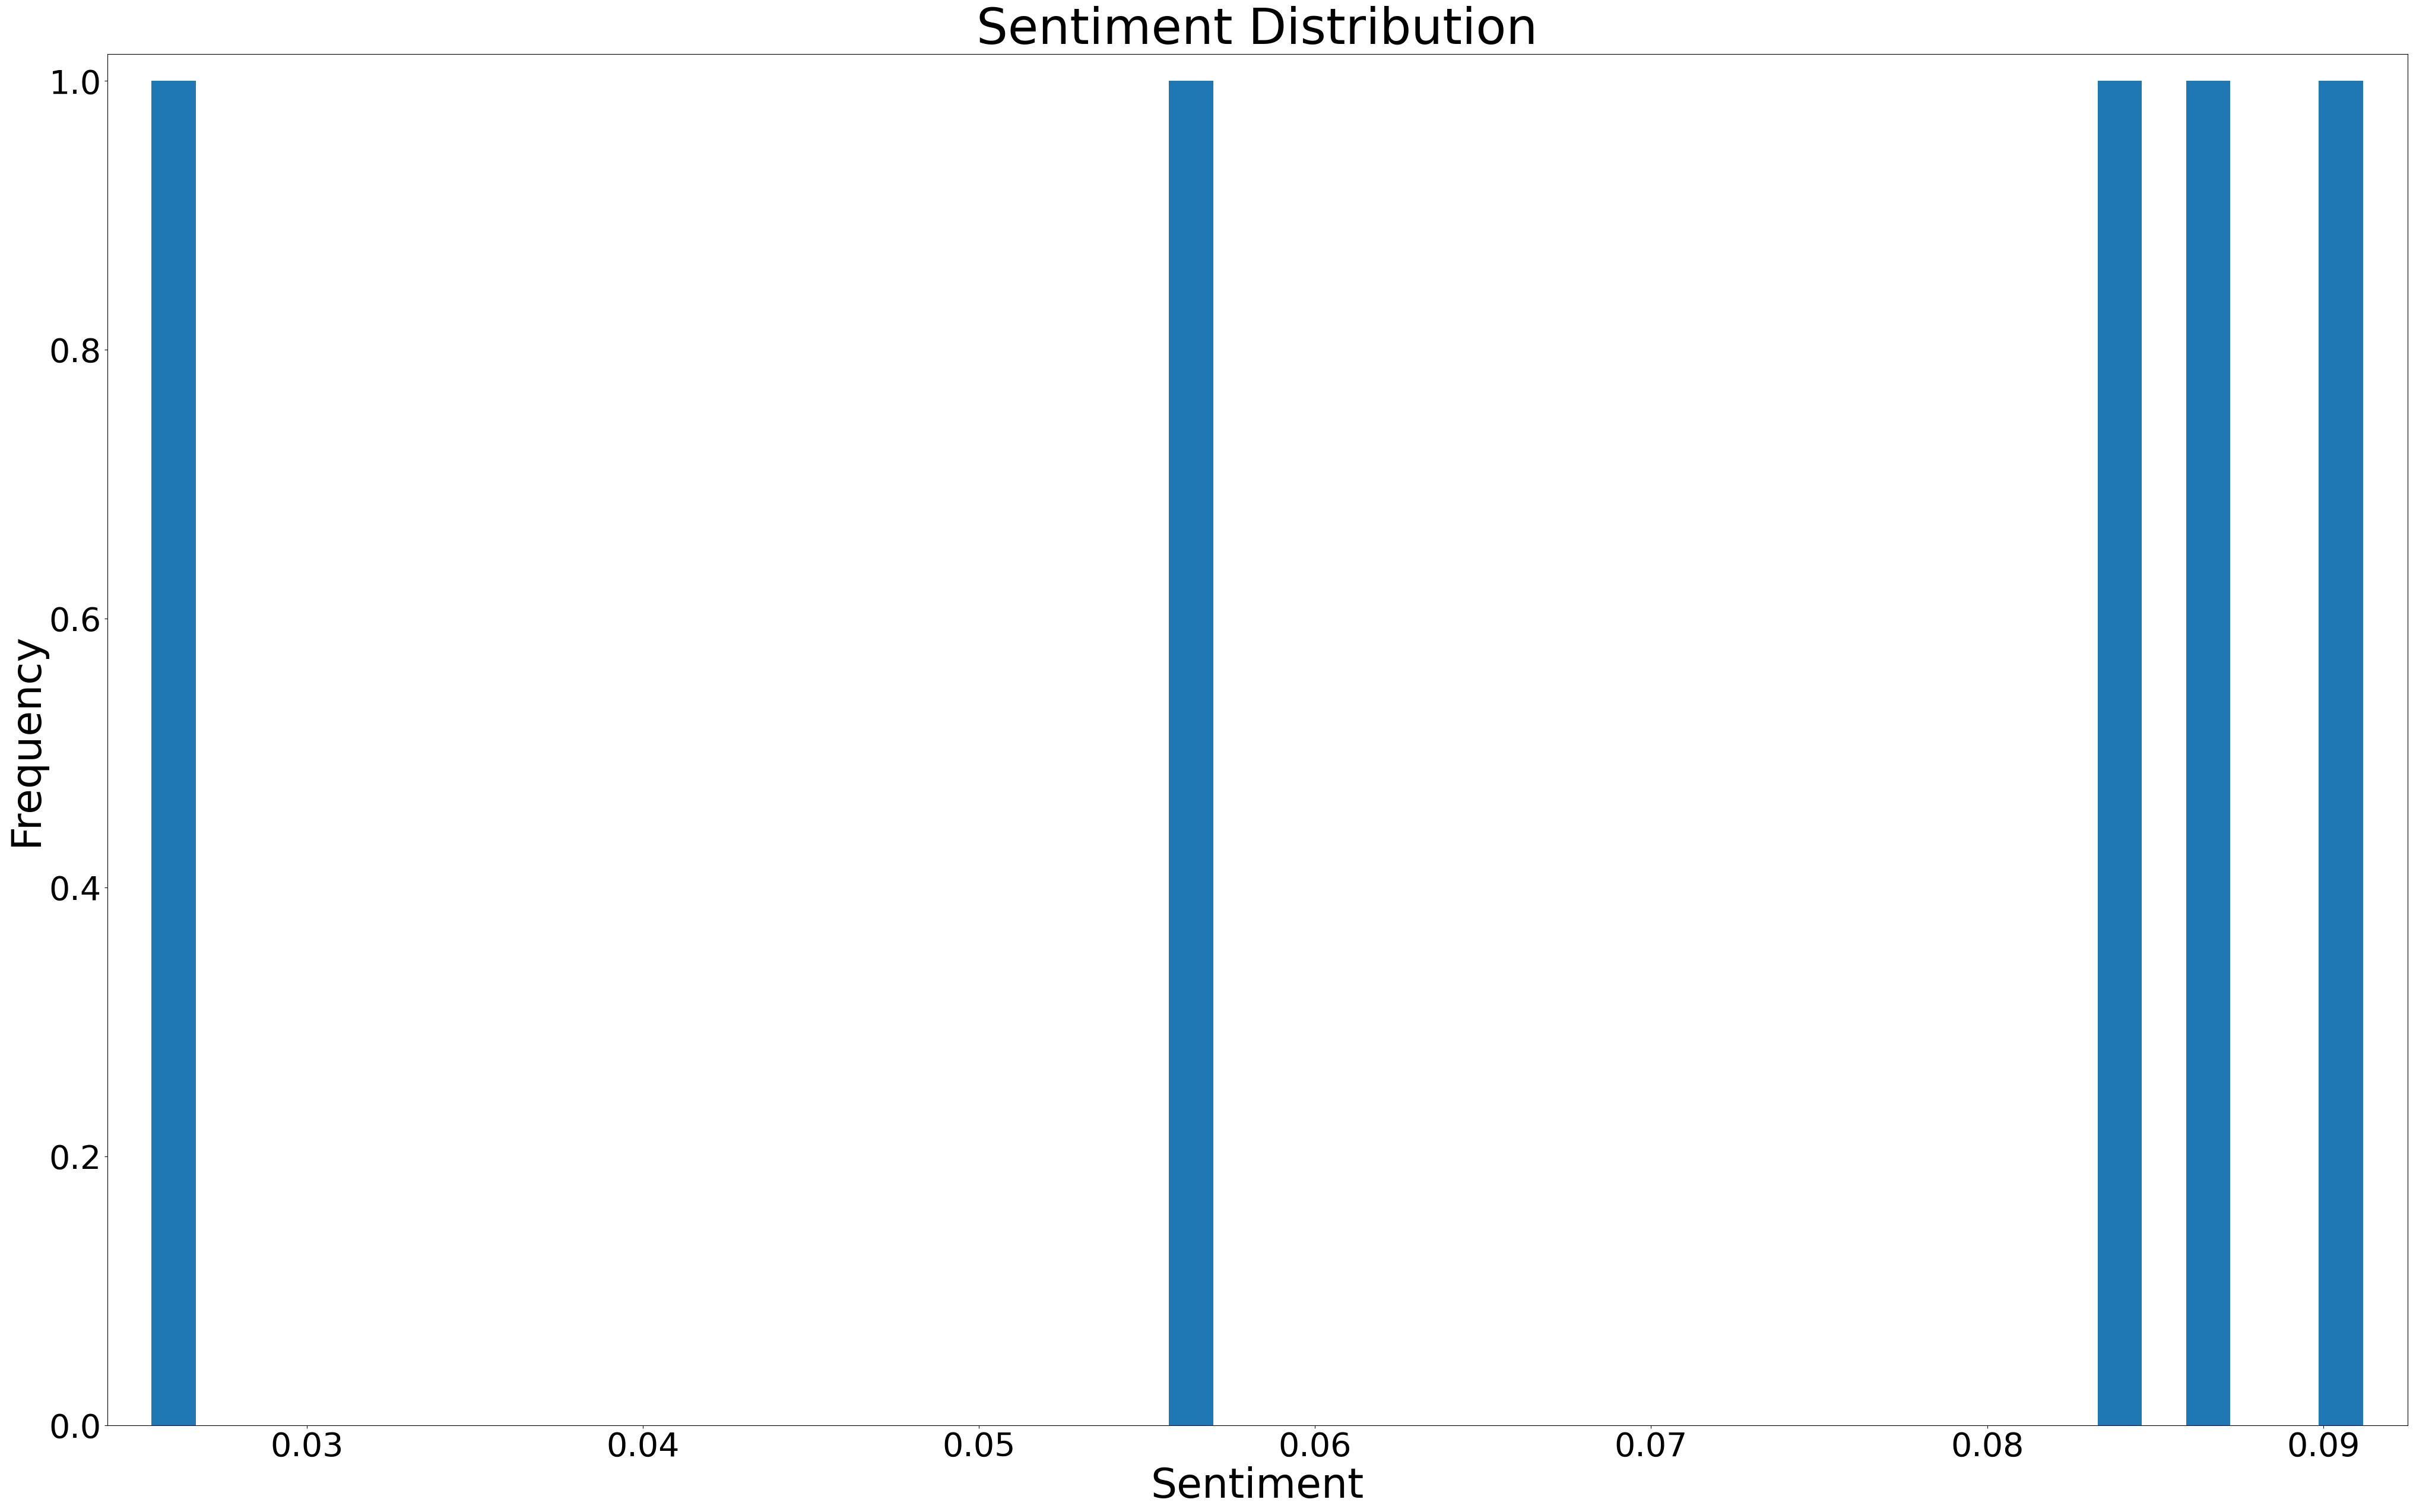

In [105]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df_preprocessed['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

### Word Cloud

In [149]:
words = df_preprocessed['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords)

KeyError: 'lemmatized'

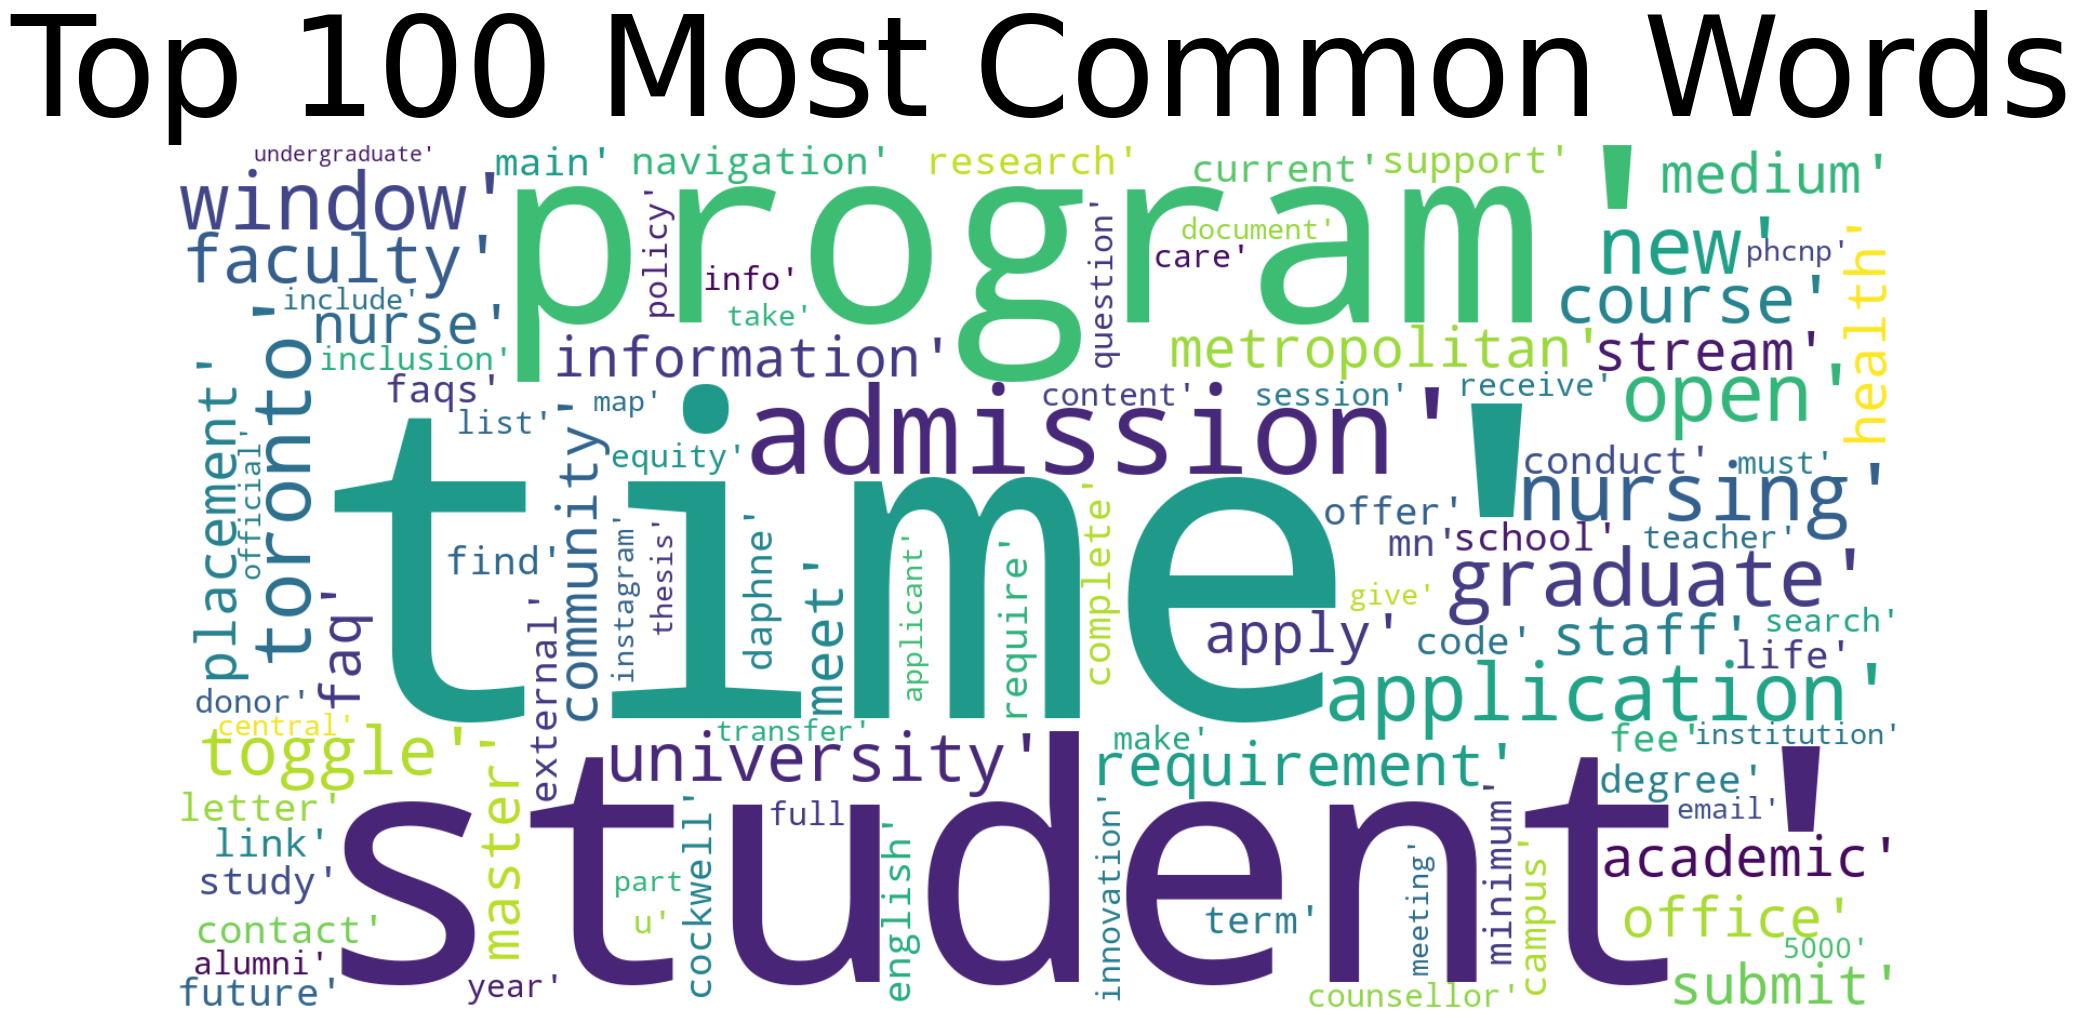

In [100]:
# 100 most common words
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

### Frequent Words

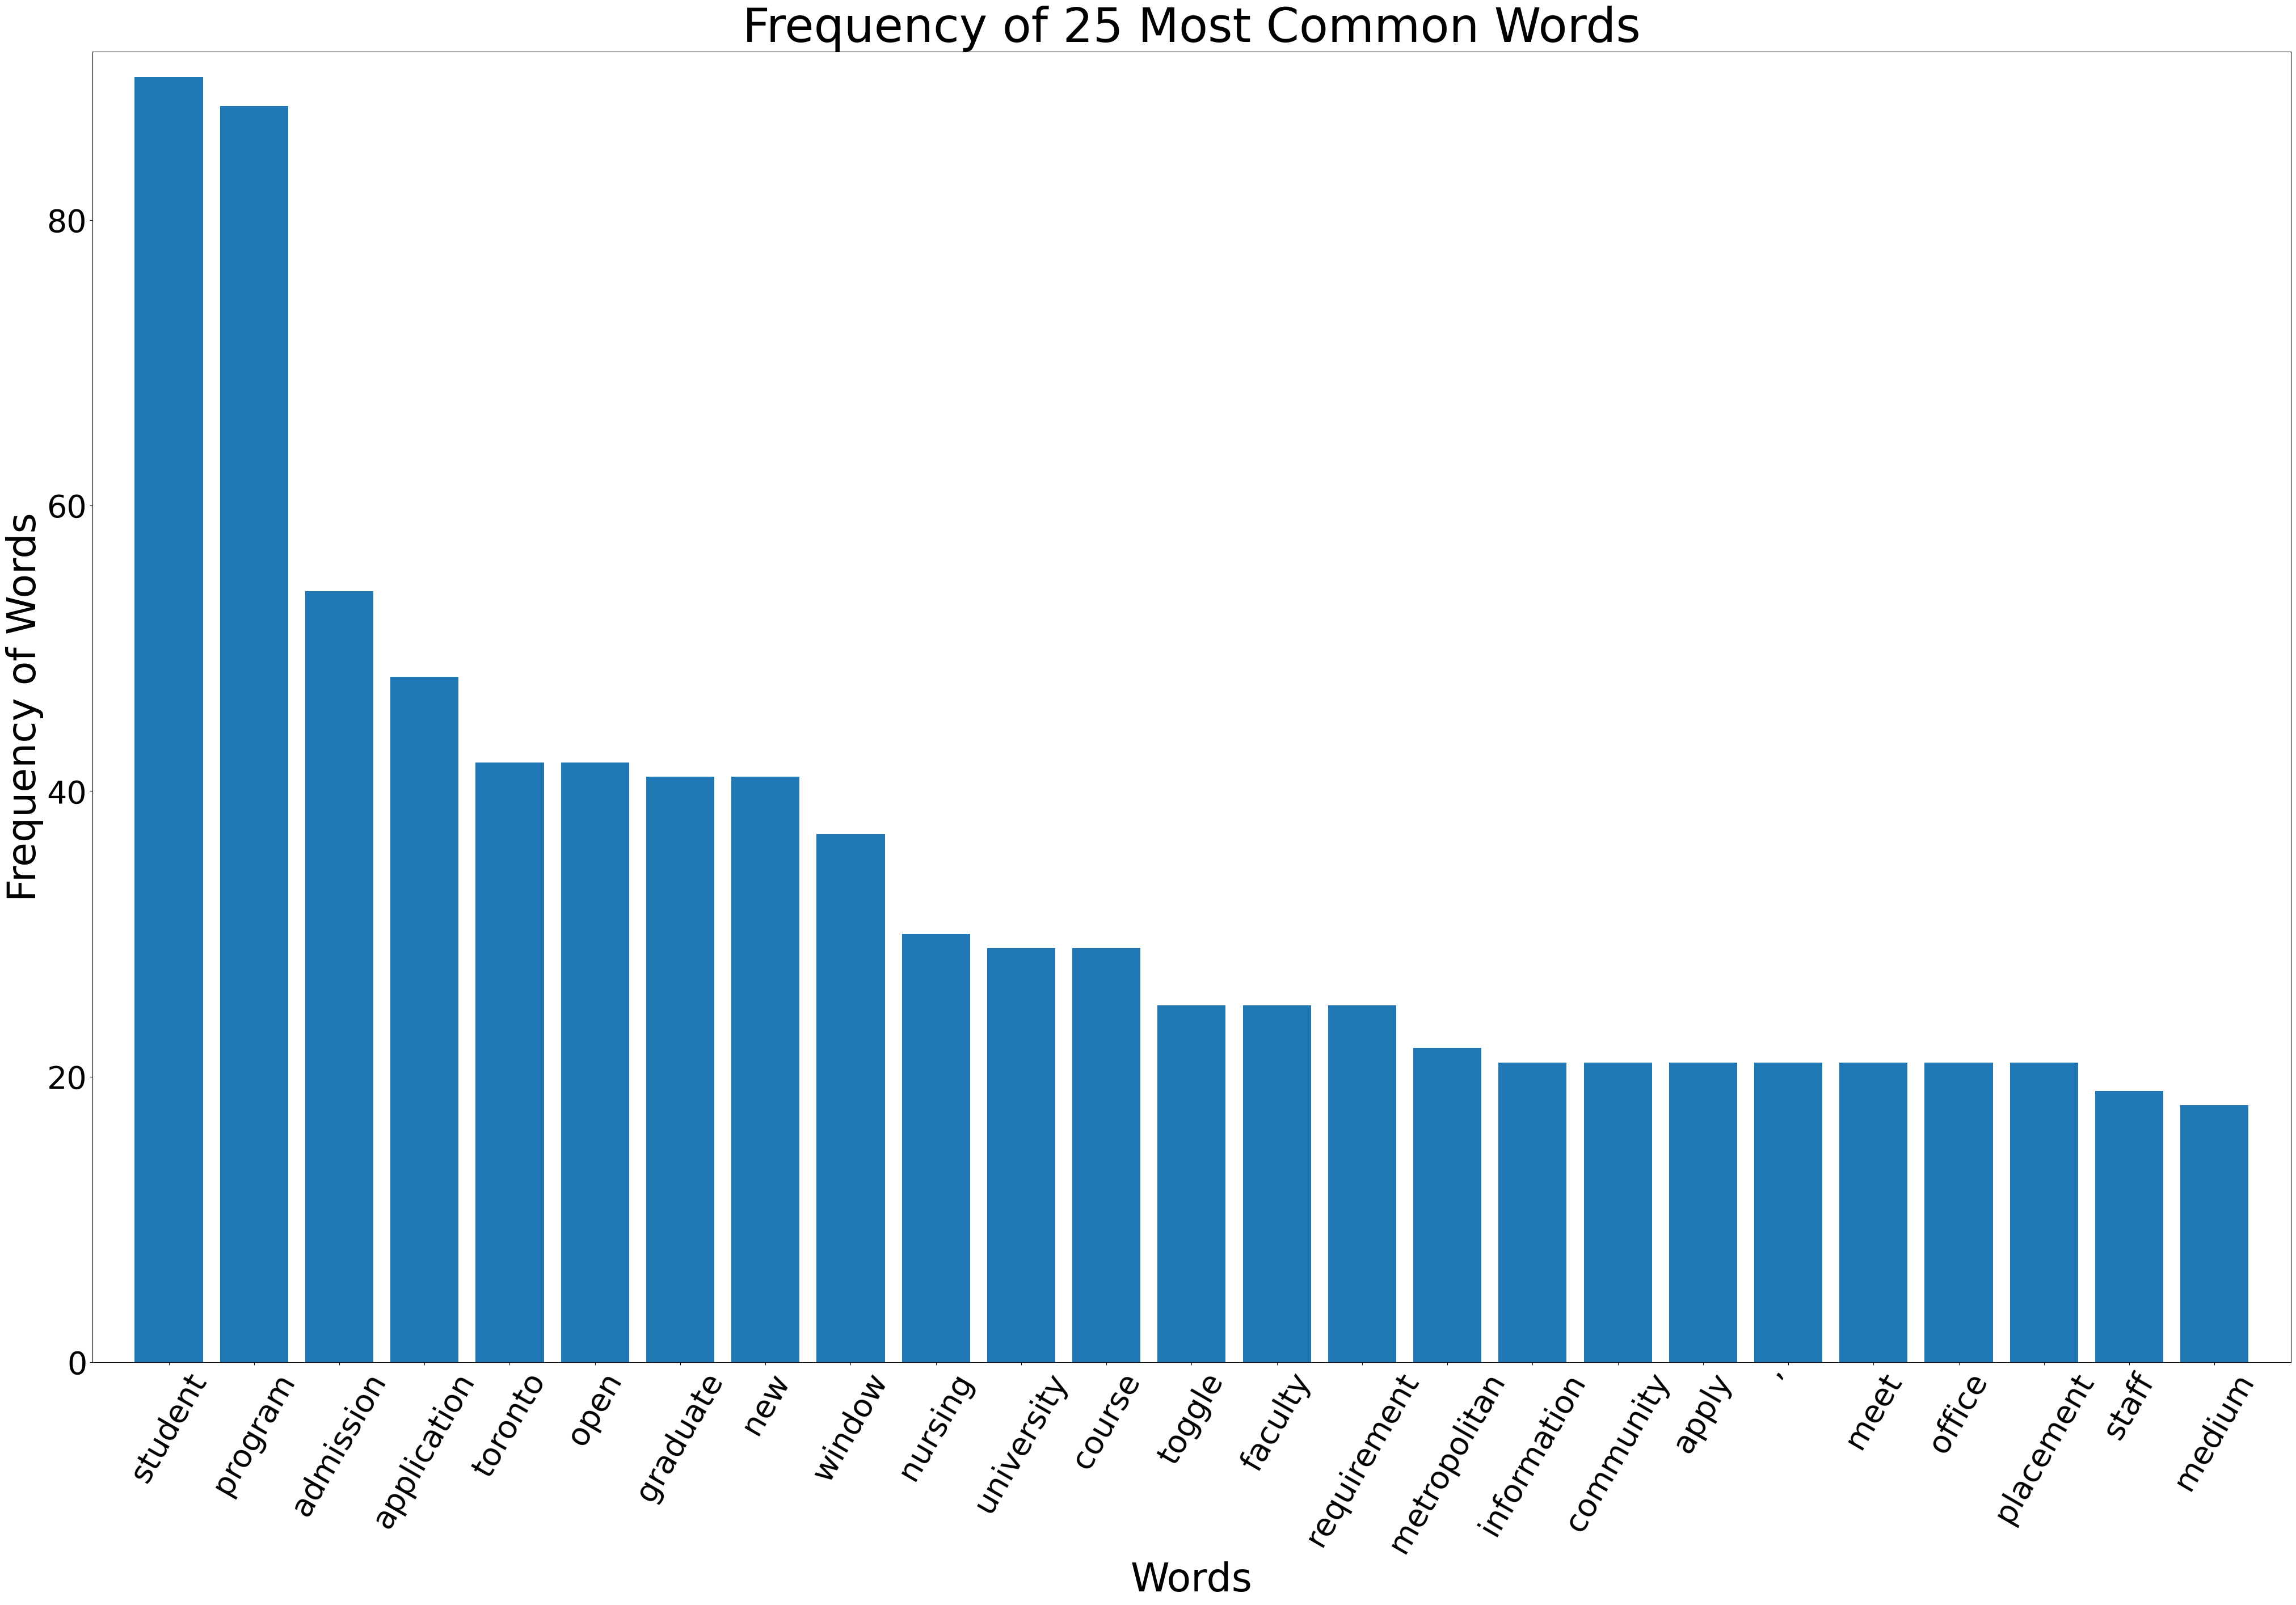

In [101]:
# Frequency of 25 most common words
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

# Open AI LLM Implementation

In [1]:
#Initializing OpenAI API
llm = ChatOpenAI( model="gpt-4o",
    temperature=0)

NameError: name 'ChatOpenAI' is not defined

In [67]:
llm.invoke("how can langsmith help with testing?")

AIMessage(content='Langsmith can help with testing by providing automated testing tools for developers to easily and efficiently test their code. This can help identify bugs and errors in the code, ensuring that the software performs as expected. Langsmith can also provide testing frameworks and libraries to help streamline the testing process and improve the overall quality of the software. Additionally, Langsmith can offer code analysis and code review services to help identify potential issues and improve code quality before testing begins.', response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 15, 'total_tokens': 104}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-71eb6f9e-094a-4ba1-85d4-b3b9db589946-0')

## Splitting Documents into chunks


In [156]:
# split the docs into chunks using recursive character splitter
def split_docs(documents,chunk_size=1000,chunk_overlap=200):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
  docs = text_splitter.split_documents(documents)
  return docs

# store the splitte documnets in docs variable
chunks = split_docs(docs)

## Embeddings

### Using Open Source Sentence Transformer Model-all-MiniLM-L6-v2

In [151]:
# embeddings using langchain
from langchain.embeddings import SentenceTransformerEmbeddings
embeddings_sentence_transformer = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\rosha\anaconda3\envs\mrp\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rosha\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

c:\Users\rosha\anaconda3\envs\mrp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Using OpenAI Embeddings

In [157]:
embeddings_openai = OpenAIEmbeddings(model="text-embedding-3-large")

## Storing Embeddings in ChromaDB Vector Store

### Storing and Testing Sentence Transformer Embeddings

In [158]:
# using chromadb as a vectorstore and storing the docs in it

db = Chroma.from_documents(docs, embeddings_sentence_transformer,persist_directory="./chroma_db")

In [160]:
# Doing similarity search  using query
query = "How to apply for Msc Data Science and Analytics?"
matching_docs = db.similarity_search(query)

matching_docs

[Document(page_content='\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ - Data Science and Analytics - Toronto Metropolitan University\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to Main Content\n\n\n\n \n\n\nToggle navigation \n\n\nToggle information \n\n\nToggle search \n\n\n\n\n\nSearch Site and People\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tInfo for \n\n\n\nFuture Students\nCurrent Students\nFaculty and Staff\nTeachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tCounsellors\nAlumni\nMedia\nDonors\n\nFuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nCurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nFaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Staff\nTeachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Counsellors\nAlumni\nMedia\nDonors\n\n\nAbout\nPrograms\nAdmissions\nCampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tLife\nResearch & Innovation\nEquity & Community Inclusion\n\nApply\nVisit\nGive\n\nmy.torontomu\n\n\n Menu\n\n\nAbout\nPrograms\nAdmissions\nCampus Life\nResearch & Innovation\nEquity & Commun

In [75]:
# Doing similarity search  using query
query = "Are graduate nursing courses online or hybrid?"
matching_docs = db.similarity_search(query)

matching_docs[0].page_content

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - Toronto Metropolitan University\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to Main Content\n\n\n\n \n\n\nToggle navigation \n\n\nToggle information \n\n\nToggle search \n\n\n\n\n\nSearch Site and People\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tInfo for \n\n\n\nFuture Students\nCurrent Students\nFaculty and Staff\nTeachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tCounsellors\nAlumni\nMedia\nDonors\n\nFuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nCurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nFaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Staff\nTeachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Counsellors\nAlumni\nMedia\nDonors\n\n\nAbout\nPrograms\nAdmissions\nCampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tLife\nResearch & Innovation\nEquity & Community Inclusion\n\nApply\nVisit\nGive\n\nmy.torontomu\n\n\n Menu\n\n\nAbout\nPrograms\nAdmissions\nCampus Life\nResearch & Innovation\nEquity & C

In [76]:
# Doing similarity search  using query
query = "How much does it cost for masters in nursing?"
matching_docs = db.similarity_search(query)

matching_docs[0].page_content

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - Toronto Metropolitan University\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to Main Content\n\n\n\n \n\n\nToggle navigation \n\n\nToggle information \n\n\nToggle search \n\n\n\n\n\nSearch Site and People\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tInfo for \n\n\n\nFuture Students\nCurrent Students\nFaculty and Staff\nTeachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tCounsellors\nAlumni\nMedia\nDonors\n\nFuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nCurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nFaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Staff\nTeachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Counsellors\nAlumni\nMedia\nDonors\n\n\nAbout\nPrograms\nAdmissions\nCampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tLife\nResearch & Innovation\nEquity & Community Inclusion\n\nApply\nVisit\nGive\n\nmy.torontomu\n\n\n Menu\n\n\nAbout\nPrograms\nAdmissions\nCampus Life\nResearch & Innovation\nEquity & C

In [77]:
# load from disk
db3 = Chroma(persist_directory="./chroma_db", embedding_function=embeddings_sentence_transformer)
docs = db3.similarity_search(query)
print(docs[0].page_content)

















Graduate admissions FAQs - Daphne Cockwell School of Nursing - Toronto Metropolitan University
    






























Skip to Main Content



 


Toggle navigation 


Toggle information 


Toggle search 





Search Site and People










 
													Info for 



Future Students
Current Students
Faculty and Staff
Teachers and
														Counsellors
Alumni
Media
Donors

Future
												Students
Current
												Students
Faculty
												and Staff
Teachers
												and Counsellors
Alumni
Media
Donors


About
Programs
Admissions
Campus
												Life
Research & Innovation
Equity & Community Inclusion

Apply
Visit
Give

my.torontomu


 Menu


About
Programs
Admissions
Campus Life
Research & Innovation
Equity & Community Inclusion























				        Daphne Cockwell School of Nursing
				    

















Home


Toggle navigation







About


Undergraduate


Graduate


Research


Central Placement Office


Experiential 

In [81]:
#Similarity Search with Score
search_results = db.similarity_search_with_score(query)

In [82]:
# Lower score is better for cosine distance
search_results[0]

(Document(page_content="\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate admissions FAQs - Daphne Cockwell School of Nursing - Toronto Metropolitan University\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to Main Content\n\n\n\n \n\n\nToggle navigation \n\n\nToggle information \n\n\nToggle search \n\n\n\n\n\nSearch Site and People\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tInfo for \n\n\n\nFuture Students\nCurrent Students\nFaculty and Staff\nTeachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tCounsellors\nAlumni\nMedia\nDonors\n\nFuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nCurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nFaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Staff\nTeachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Counsellors\nAlumni\nMedia\nDonors\n\n\nAbout\nPrograms\nAdmissions\nCampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tLife\nResearch & Innovation\nEquity & Community Inclusion\n\nApply\nVisit\nGive\n\nmy.torontomu\n\n\n Menu\n\n\nAbout\nPrograms\nAdmissions\nCampus Life\nResearch &

### Storing and Testing OpenAI Embeddings

In [85]:
db_new = Chroma.from_documents(docs, embeddings_openai)

In [86]:
# Doing similarity search  using query
query = "Are graduate nursing courses online or hybrid?"
matching_docs = db_new.similarity_search(query)

matching_docs[0].page_content

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGraduate FAQs - Daphne Cockwell School of Nursing - Toronto Metropolitan University\r\n    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to Main Content\n\n\n\n \n\n\nToggle navigation \n\n\nToggle information \n\n\nToggle search \n\n\n\n\n\nSearch Site and People\n\n\n\n\n\n\n\n\n\n\n \r\n\t\t\t\t\t\t\t\t\t\t\t\t\tInfo for \n\n\n\nFuture Students\nCurrent Students\nFaculty and Staff\nTeachers and\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\tCounsellors\nAlumni\nMedia\nDonors\n\nFuture\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nCurrent\r\n\t\t\t\t\t\t\t\t\t\t\t\tStudents\nFaculty\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Staff\nTeachers\r\n\t\t\t\t\t\t\t\t\t\t\t\tand Counsellors\nAlumni\nMedia\nDonors\n\n\nAbout\nPrograms\nAdmissions\nCampus\r\n\t\t\t\t\t\t\t\t\t\t\t\tLife\nResearch & Innovation\nEquity & Community Inclusion\n\nApply\nVisit\nGive\n\nmy.torontomu\n\n\n Menu\n\n\nAbout\nPrograms\nAdmissions\nCampus Life\nResearch & Innovation\nEquity & Community In